This notebook implements many differents solutions for the PLN model. This is more a test of the  differents methods since we are building ourselves the data, and we know the true parameter Sigma and beta. This is just to check the method. The best solution is implemented in the fastPLN.py file for any data. An example is done at the end of the notebook. 

In [20]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from utils import Poisson_reg, sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math 
import time 
plt.style.use('ggplot')

import threading

import numpy as np
import seaborn as sns 
import torch
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
from sklearn.linear_model import LinearRegression
torch.set_default_dtype(torch.float64)

In [22]:
#get the device. can be used with GPU
if torch.cuda.is_available(): 
    device = torch.device('cuda') 
else : 
    device = torch.device('cpu')
print('device : ', device)

device :  cpu


In [7]:
class PLN_full():
    def __init__(self, class_optimizer = torch.optim.Rprop): 
        '''
            Initialization. We only define some useful stuff. The intialization of the
            parameters is done int the init_data() function. 
        '''
        self.old_loss = 1
        
        self.class_optimizer = class_optimizer
        
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def init_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. We 
        also intialize the parameters.
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0].to(device);self.O = data[1].to(device);self.covariates = data[2].to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]

        #model parameter 
        noise = torch.randn(self.p)
        self.Sigma =  (torch.diag(noise**2)+ 1e-1).to(device) 
        self.Sigma.requires_grad_(False)#we won't use gradients on Sigma
        self.beta = torch.rand((self.d, self.p)).to(device)
        self.beta.requires_grad_(True)
        #variational parameter
        self.M = torch.randn((self.n,self.p)).to(device)
        self.M.requires_grad_(True)
        self.S = torch.randn((self.n,self.p)).to(device)
        self.S.requires_grad_(True)
        
        # C is a matrix in the model but it is a vector here of size p(p+1)/2 here. It 
        # is simpler to use this way. It allows us to have only p(p+1)/2 parameters instead of p^2
        self.C = torch.clone(mat2vec_lower_tridiag(torch.cholesky(self.Sigma))).to(device)
        self.C.requires_grad_(True)
        self.requires_tridiag = True 
        self.params = {'S' : self.S,'M': self.M, 'beta' : self.beta, 'Sigma' : self.Sigma, 'C' : self.C}
        
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same thing but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    
    
    ####################### parametrisation centered in 0, variance Sigma  ################
    
    
    
    
    
    def compute_first_ELBO(self):
        '''
        compute the ELBO with the parametrisation centered in 0 and variance Sigma. 
        '''
        return first_ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    def compute_profile_ELBO(self): 
        '''
        compute the ELBO from the profiled formula, 
        i.e. we replace Sigma with its closed form in the formula. does not 
        work well in practice.
        '''
        self.Sigma = first_closed_Sigma(self.M,self.S) # we update Sigma 
        gain = profile_ELBO(self.Y,self.O,self.covariates,self.M,self.S, self.Sigma,self.beta)
        return gain
    
    
    ##################### parametrisation centered in 0 and unit variance ##################
    
    
    
    
    def compute_ELBO_PCA(self): 
        '''
        compute the ELBO from the PCA parametrization.
        '''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_PCA_tridiag(self): 
        '''
        compute the ELBO when C is a vector that encodes a tridiagonal Matrix 
        from the PCA parametrisation
        '''
        matC = vec2mat_lower_tridiag(self.C)
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,matC ,self.beta)
    
    
    ####### parametrisation centered in 0 and unit variance #########
    
    
    
    def full_grad_ascent_PCA(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta) with the loss from the PCA
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C,self.beta], lr = lr)
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma since we optimize in C. 
        self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_PCA_tridiag,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
        
        
        
        
    ########## parametrisation centered in X@\beta, variance C.C.T ###########
    

    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C, self.beta], lr = lr)
        
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_tridiag,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
        
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = True 
        self.optimizer = self.class_optimizer([self.S,self.M,self.C], lr = lr)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 

        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_tridiag ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            if verbose : 
                print(' i : ', i )
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            if verbose and i %50 == 0 : 
                print('beta closed')
                sns.heatmap(self.Sigma)
                plt.show()
            
        
    ########## parametrisation centered in X@\beta and variance Sigma ###############
    
    
    
    def profile_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True):
        
        '''
        gradient ascent with the profiled formula. We replace Sigma by the argmax in some part 
        to avoid computing the inverse of Sigma. does not work well. 
        args : same as above     
        '''
        self.extract_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        # we first do one simple gradient ascent to avoid computing the log of zero. (does not work very well yet)
        self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = 0 , N_epoch = 20 ,
                requires_closed_Sigma= True, verbose = verbose)
        
        self.torch_gradient_ascent(self.optimizer, self.compute_profile_ELBO,self.params,tolerance = 0,  
                            N_epoch = N_epoch,verbose = verbose)
    
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.5, tolerance = 0, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only update beta and sigma with their closed form. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.take_C = False
        self.init_data(data)
        self.optimizer = self.class_optimizer([self.S,self.M], lr = lr)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
                
            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = False
        
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            if verbose and i %50 == 0: 
                print('Sigma closed')
                sns.heatmap(self.Sigma)
                plt.show()
                
                
           
    ########## parametrisation centered 0 and variance Sigma ###############
                
    
                
    def first_VEM(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ): 
        '''
        VEM where we update Sigma with its closed form.
        each N_epoch_max iteration.  We use another parametrisation, the one in PLN_test.ipynb. 
        This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.init_data(data)
        self.take_C = False
        self.optimizer = self.class_optimizer([self.S,self.M,self.beta], lr = lr)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max, verbose = verbose)
            with torch.no_grad():
                self.Sigma = 1/self.n*(torch.mm(self.M.T,self.M) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))
                
                
    def get_Sigma(self): 
        '''
        simple fucntion to get Sigma. We do this since we are taking either C or Sigma as parameter. 
        (either Sigma or C will be changed from its initialization value, we take the one 
        that is being optmized)
        '''
        if self.take_C : 
            return vec2mat_lower_tridiag(self.C)
        else : 
            return self.Sigma.detach()
        

    

    # gradient ascent function, core function of the class. 
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we will
                                call compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            if torch.isnan(loss).item() == True : 
                #print('NAN')
                pass
            optimizer.step()
            
            delta = self.old_loss - loss.item() 
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            
            self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2).item())
            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%100 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                if i % 500 == 21 : 
                    sns.heatmap(self.Sigma)
                    plt.show()
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
 
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
        
    
    ### we will build all the algorithms based on the previous function. The function will 
    ### basically be the same, we will change the gain considered (depends on the parametrisation we take 
    ### mainly). We will also update the parameters if we have closed form. 
    
    # we compute here the gradients with respect to all 
    #the parameters when taking the PCA parametrisation
    def gradPCA_S(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = -1/2*torch.multiply(self.S,torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),CrondC))
        second = torch.div(1,self.S)
        third = -self.S
        return first + second +third
    
    def gradPCA_C(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first = torch.mm(self.Y.T,self.M) 
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        exp = torch.exp(A + 1/2*torch.mm(SrondS,CrondC.T))
        second = -1/2*torch.mm(exp.T,self.M)-1/2*torch.multiply(matC,torch.mm(exp.T,SrondS))
        return first + second
    
    def gradPCA_beta(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first_term = torch.mm(self.covariates.T,self.Y)
        second_term = -1/2*torch.mm(
                             self.covariates.T,
                             torch.exp(self.O+torch.mm(self.covariates,self.beta)+torch.mm(self.M,matC.T)+1/2*torch.mm(SrondS,CrondC.T))
                             )
        return first_term+second_term
    def gradPCA_M(self):
        try : 
            matC = vec2mat_lower_tridiag(self.C)
        except : matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = torch.mm(self.Y,matC)
        second = -1/2*torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),matC)
        third = -self.M
        return first + second+third
    


In [8]:
# Here are the gradients with the parametrisation centered in X\beta and variance C@C.T above. 
# we compute it just as a sanity check since it is computed with pytorch
def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T

def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad

In [9]:
#we define some closed forms for the update
def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n,p = M.shape
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/(n)*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0)))

    
def first_closed_Sigma(M,S): 
    '''
    closed form for Sigma with the parametrisation of the first notebook
    '''
    n = M.shape[0]
    return 1/n*(torch.mm(M.T,M) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)

In [10]:
#Here we compute the ELBO for all the different parametrization


######## Parametrisation centered in 0 and unit variance #########
def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO from the PCA parametrisation. 
    '''
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    first = torch.sum(torch.multiply(Y,A))
    second = torch.sum(-1/2*torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T)))
    third = torch.sum(+1/2*torch.log(SrondS))
    fourth = torch.sum(-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return first +second + third + fourth


###### parametrisation centered in X@beta and variance C@C.T ######



def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''

    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C in argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO with this matrix.
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)


####### parametrisation centered in 0 and Variance Sigma ##########




def first_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    ''' 
    computes the ELBO. We simply apply the formula given above. 
    '''
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    tmp = -n/2*torch.log(torch.det(Sigma)) #-1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))
    tmp += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    tmp -= 1/2*torch.trace(torch.mm(torch.mm(M.T, M) + torch.diag(torch.sum(SrondS, dim = 0)), inv_Sigma))
    tmp += 1/2*torch.sum(torch.log(SrondS))
    return tmp

def profile_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    '''
    computes the profiled ELBO. We replaced Sigma with its closed form to 
    avoid computing the inverse of Sigma. Should be faster, but does not work very well in practice. 
    Indeed, we have some nan values that appears for large values of p. 
    '''
    n = Y.shape[0]
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    J = -n/2*torch.log(torch.det(Sigma))
    J  += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    J-= n*p/2
    J += 1/2*torch.sum(torch.log(SrondS))
    return J 


########## parametrisation centered in X@beta and variance Sigma #########



def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is not C but Sigma. basically, we will replace 
    CC.T by Sigma 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

Parametrisation centered in $X\beta$ and variance $C$ 
$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

--------------
Parametrisation centered in $X\beta$ and variance $\Sigma$ 
$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

Parametrisation centered in 0 and unit variance. 
$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top}+\frac{ (S \odot S)(C\odot C)^{\top}}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

In [1]:
def launch_optimizers(dict_optimizers,N_iter, lr):
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         lr : float. the learning rate of each optimizer.
    '''
    ts = list()
    models = list()
    Nb_each_iter = 20 
    for name, optimizer in dict_optimizers.items(): 
        model = PLN_full(class_optimizer = optimizer)
        t = threading.Thread(target =model.full_grad_ascent_PCA,
              args = [data, N_iter          ,lr     , False] )
        #t = threading.Thread(target =model.VEM_both_closed,
        #      args = [data, N_iter           ,Nb_each_iter      , lr,  0.01 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
    return dict(zip(dict_optimizers.keys(), models))

def launch_lr(dict_lr,N_iter, optimizer = torch.optim.Rprop): 
    '''
    launch some optimizers to compare them after. 
    args : 
         dict_lr : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         optimizer : the optimizer we want to use for the model
    '''
    ts = list()
    models = list()
    Nb_each_iter = 1
    for name, lr in dict_lr.items(): 
        model = PLN_full(class_optimizer = optimizer)
        #t = threading.Thread(target =model.full_grad_ascent_PCA, ## uncomment this if you want to use the PCA
        #      args = [data, N_iter          ,lr     , False] )   ## parametrization.
        t = threading.Thread(target =model.VEM_both_closed,
              args = [data, N_iter, Nb_each_iter,       lr,  0 , False] )
        t.start()
        ts.append(t)
        models.append(model)
    for t in ts : 
        t.join()
        
    return dict(zip(dict_lr.keys(), models))

def launch_models(class_optim,N_iter, lr,Nb_each_iter = 8): 
    ''' 
    launch all the models. we use parallelization to go faster. 
    args : 
        class_optim : class of optimizer. should be torch.optim.Rprop for instance. 
        lr : float. learing rate of the optimizer. 
        Nb_each_iter : int. the number of iteration for each VEM step. 
    '''
    model_VEM_beta = PLN_full( class_optimizer = class_optim)
    model_VEM_Sigma = PLN_full( class_optimizer = class_optim)
    model_VEM_both = PLN_full(class_optimizer = class_optim)
    model_full = PLN_full( class_optimizer = class_optim)
    model_PCA = PLN_full(class_optimizer = class_optim)
    model_first = PLN_full(class_optimizer = class_optim)
    model_profile = PLN_full(class_optimizer = class_optim)
    
    t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
              args = [data, N_iter           ,Nb_each_iter            ,lr            , 0.1, False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
              args = [data, N_iter           ,Nb_each_iter     ,lr, 0.1             , False] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
              args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , True] )
                     #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True

    t_full = threading.Thread(target =model_full.full_grad_ascent,
              args = [data, N_iter*8           ,3*lr     , False] )
                     #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 

    t_PCA = threading.Thread(target =model_PCA.full_grad_ascent_PCA, 
             args = [data,  N_iter*8,   3*lr,              False])
    t_first =  threading.Thread(target =model_first.first_VEM,
              args = [data, N_iter           ,Nb_each_iter              ,lr     , 0.1             , False] )

    t_profile = threading.Thread(target = model_profile.profile_grad_ascent, 
                        args =[data, N_iter*13, 3*lr, False ] )

    t0 = time.time()
    
    
    #we launch all the models
    t_beta.start()
    t_Sigma.start()
    t_both.start()
    t_full.start()
    t_PCA.start()
    #t_first.start()
    #t_profile.start()

    
    #we wait for the models to finish
    t_beta.join()
    t_Sigma.join()
    t_both.join()
    t_full.join()
    t_PCA.join()
    #t_profile.join()
    #t_first.join()
    print('Execution time : ', time.time()-t0)

    dict_models = {'closed_beta' : model_VEM_beta,'closed_Sigma' : model_VEM_Sigma, 
              'both_closed' :model_VEM_both, 'full' : model_full, 
                  'PCA_formula': model_PCA}
    return dict_models

def compare_models(dict_models,name_doss, percentage_kept = 1, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        'name_doss' : str. the name of the file you want to save the graphic. 
        'percentage_kept' float . should be positive and lower than 1
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        length = len(abscisse)
        
        ax[2].plot(abscisse[-int(length*percentage_kept):], model.ELBO_list[-int(length*percentage_kept):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    if save : 
        plt.savefig(name_doss)
    plt.show()
    
def show_Sigma(dict_model): 
    for name,model in dict_model.items():
        print('model : ', name)
        try : 
            sns.heatmap(model.get_Sigma())
            plt.show()
            print(' MSE : ', np.mean((model.get_Sigma()- true_Sigma.numpy())**2))
        except : pass 
    print('true Sigma : ', sns.heatmap(true_Sigma.numpy()))

NameError: name 'torch' is not defined

In [2]:
def vec2mat_lower_tridiag(vectC):
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n)).to(device)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+2# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    coef_toep = 0.9
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(coef_toep**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(coef_toep**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

# Data generation

In [18]:
d = 4 # nb of cavariates
n = 4000; p = 200

## Generate the true parameters and some data according to the true parameters. 

In [26]:
#torch.manual_seed(0)
#true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
true_Sigma = build_block_Sigma(p,20).to(device)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p).to(device)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma.to(torch.device('cpu')),true_beta.to(torch.device('cpu')), O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)
data = [Y_sampled.double(), O, covariates]

### Here we print the MLE for $\beta$ and $\Sigma$ in the latent layer 
Note that in practice we don't have access to the latent layer, but here we do since we generate the data ourselves. 

## $\Sigma$ MLE

MLE :


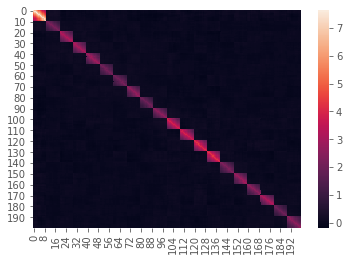

true Sigma


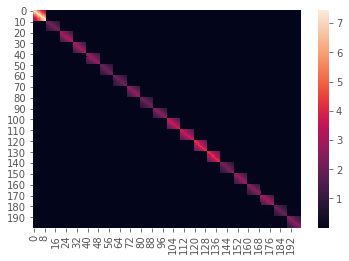

Best MSE we can have (in our dream):  tensor(0.0023)


In [110]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z_sampled, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z_sampled.shape[0]*((Z_sampled-mu_MLE).T)@(Z_sampled-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(true_Sigma.to(torch.device('cpu')))
plt.show(bisous pied)
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-true_Sigma)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

### $\beta$ MLE

In [111]:
target = Z_sampled+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
print('MSE beta in the latent layer: ', torch.mean((beta_dream-true_beta)**2))

MSE beta in the latent layer:  tensor(0.0074)


## best model : closed form for $\beta$ and $\Sigma$

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.38512
 MSE with beta :  1.3612
ELBO :  131358.42067
Delta :  131359.42067288904
---------------------------------Maximum number of iterations reached :  20 last delta =  688.2875731512904
 MSE with Sigma :  0.38512
 MSE with beta :  1.3612
both closed


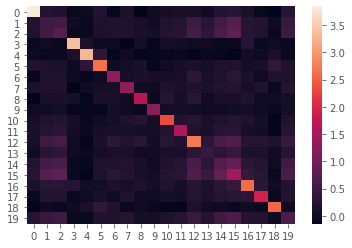

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.19475
 MSE with beta :  0.44578
ELBO :  2134542.77147
Delta :  18043.55003267061
---------------------------------Maximum number of iterations reached :  20 last delta =  62.16038802731782
 MSE with Sigma :  0.19475
 MSE with beta :  0.44578
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.11609
 MSE with beta :  0.24291
ELBO :  2150893.44086
Delta :  2750.3423026138917
---------------------------------Maximum number of iterations reached :  20 last delta =  16.058678819332272
 MSE with Sigma :  0.11609
 MSE with beta :  0.24291
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08335
 MSE with beta :  0.1668
ELBO :  2153392.56133
Delta :  608.1277859588154
---------------------------------Maximum number of iterations reached :  20 last delta =  1.2619991372339427
 MSE with Sigma :  0.08335
 MSE with beta :  0.1668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.06997
 MSE with beta 

In [59]:
best_model = PLN_full()
%time best_model.VEM_both_closed(data,Number_VEM_step =30,verbose=True, lr = 1)

## Comparison 

### We have many hyperparameters for the model, such as the learning rate, the optimizer, the parametrization  and the choice of the closed form update. We use threadings to go faster.  Allows to launch all the models at the same time. 

# Comparison of optimizer  

In [60]:
dict_optimizers = {'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                   'Adamax' : torch.optim.Adamax,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop}

In [77]:
dict_model_optim = launch_optimizers(dict_optimizers,10000,0.1)

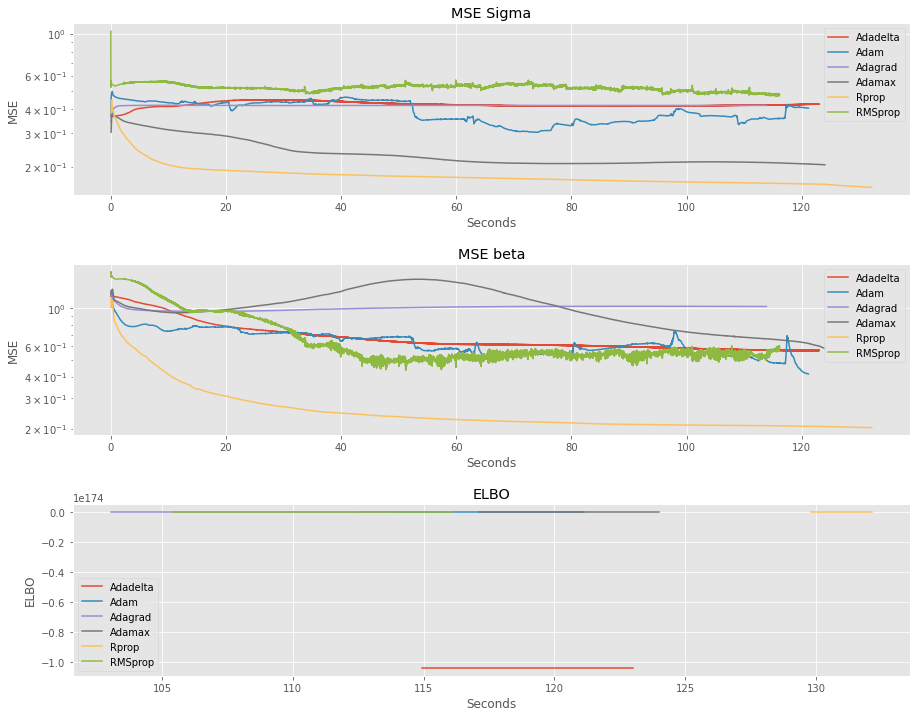

In [78]:
compare_models(dict_model_optim,'', percentage_kept=0.1)

### Comparison of parametrization

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.28509
 MSE with beta :  1.44097
ELBO :  -38779531.5816
Delta :  -38779530.58160321
---------------------------------Maximum number of iterations reached :  8 last delta =  11744328.048756406
 MSE with Sigma :  0.28509
 MSE with beta :  1.44097
both closed


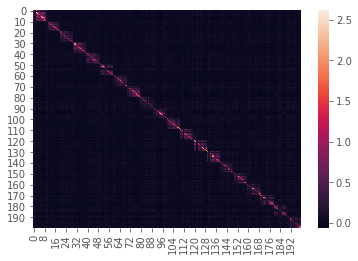

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.23336
 MSE with beta :  0.52217
ELBO :  70801313.545
Delta :  13968719.451988123
---------------------------------Maximum number of iterations reached :  8 last delta =  10682099.531685978
 MSE with Sigma :  0.23336
 MSE with beta :  0.52217
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08092
 MSE with beta :  0.21345
ELBO :  166715276.01481
Delta :  7001667.105386138
---------------------------------Maximum number of iterations reached :  8 last delta =  400458.4674332738
 MSE with Sigma :  0.08092
 MSE with beta :  0.21345
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04491
 MSE with beta :  0.12142
ELBO :  178362706.99786
Delta :  136036.95627880096
---------------------------------Maximum number of iterations reached :  8 last delta =  13249.4990080297
 MSE with Sigma :  0.04491
 MSE with beta :  0.12142
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02813
 MSE with beta

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00594
 MSE with beta :  0.00856
ELBO :  178986100.02676
Delta :  11.355436235666275
---------------------------------Maximum number of iterations reached :  8 last delta =  0.38610967993736267
 MSE with Sigma :  0.00594
 MSE with beta :  0.00856
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0059
 MSE with beta :  0.00846
ELBO :  178986120.18308
Delta :  9.889095485210419
---------------------------------Maximum number of iterations reached :  8 last delta =  0.3378879725933075
 MSE with Sigma :  0.0059
 MSE with beta :  0.00846
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00586
 MSE with beta :  0.00837
ELBO :  178986137.33315
Delta :  8.352704614400864
---------------------------------Maximum number of iterations reached :  8 last delta =  0.30309125781059265
 MSE with Sigma :  0.00586
 MSE with beta :  0.00837
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00583
 MSE with

In [112]:
#dict_models_adadelta = launch_models(torch.optim.Adadelta)
dict_models_Rprop = launch_models(torch.optim.Rprop,N_iter = 50, lr = 0.1)

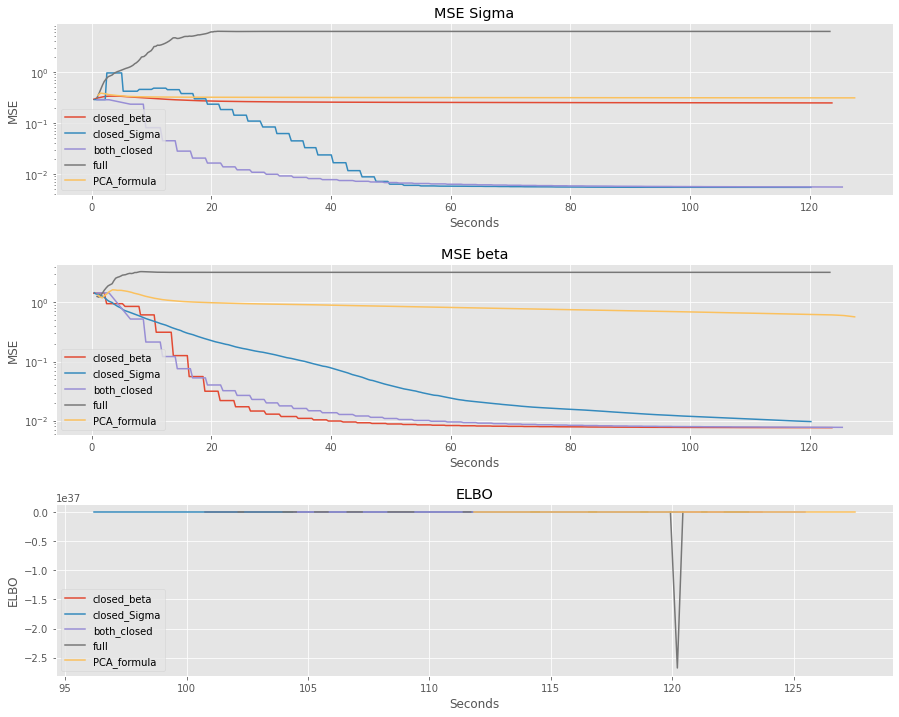

In [115]:
compare_models(dict_models_Rprop,'',percentage_kept = 0.2)

### comparison of learning rates

In [119]:
dict_lr = dict()

for i in range(6): 
    dict_lr['lr = '+ str(10**(-i))] = 10**(-i)

In [120]:
result_lr = launch_lr(dict_lr,10, optimizer = torch.optim.Rprop)

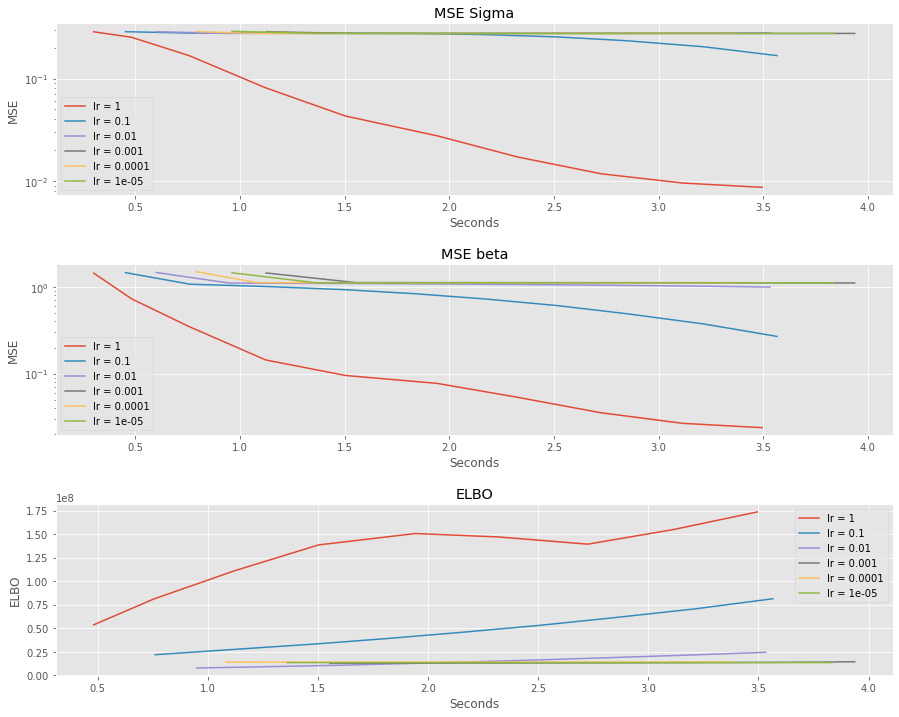

In [121]:
compare_models(result_lr,'comparison_lr_Rprop_both_closed',percentage_kept = 0.9, save = False)

# All the different parametrisation

# Parametrisation centered in $X\beta$ and variance $CC^{\top}$

### VEM were we use only the closed form for  $\beta$ 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.3579
 MSE with beta :  1.32099
ELBO :  66114.85816
Delta :  66115.8581573459
---------------------------------Maximum number of iterations reached :  20 last delta =  36943.269396944204
 MSE with Sigma :  0.19482
 MSE with beta :  1.32099
 i :  0
beta closed


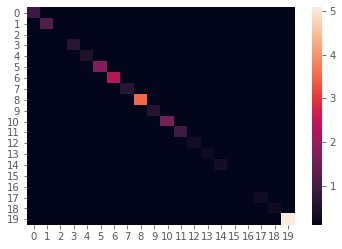

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.18469
 MSE with beta :  0.11871
ELBO :  2074798.95412
Delta :  1034.1236541981343
---------------------------------Maximum number of iterations reached :  20 last delta =  5.729666248895228
 MSE with Sigma :  0.16112
 MSE with beta :  0.11871
 i :  1
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.16128
 MSE with beta :  0.09319
ELBO :  2154286.84441
Delta :  43.4185425452888
---------------------------------Maximum number of iterations reached :  20 last delta =  0.056324766017496586
 MSE with Sigma :  0.16083
 MSE with beta :  0.09319
 i :  2
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.16088
 MSE with beta :  0.09192
ELBO :  2154320.93964
Delta :  4.110856325831264
---------------------------------Maximum number of iterations reached :  20 last delta =  0.035390285309404135
 MSE with Sigma :  0.15986
 MSE with beta :  0.09192
 i :  3
iteration number:  0
-------UPDATE-------
 MSE with Sig

In [79]:
model_VEM_beta = PLN_full()
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =10,verbose=True, lr = 0.05)

### Gradient descent on all the parameters

In [81]:
model = PLN_full()
%time model.full_grad_ascent(data, N_epoch = 10,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.3714
 MSE with beta :  1.28568
ELBO :  201885.14284
Delta :  201886.1428388085
---------------------------------Maximum number of iterations reached :  10 last delta =  12578.784524381801
 MSE with Sigma :  0.35838
 MSE with beta :  1.27496
CPU times: user 185 ms, sys: 4.42 ms, total: 189 ms
Wall time: 32 ms


# Parametrisation centered in $X\beta$ and variance $\Sigma$

### VEM were we use only the closed form for  $\Sigma$ 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.28701
 MSE with beta :  2.93832
ELBO :  -28832653.53202
Delta :  -28832652.53202067
---------------------------------Maximum number of iterations reached :  20 last delta =  164700.2835302055
 MSE with Sigma :  0.28701
 MSE with beta :  1.14885
Sigma closed


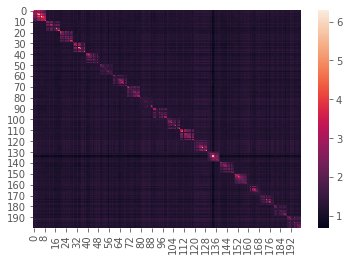

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.39668
 MSE with beta :  1.10561
ELBO :  176521872.56405
Delta :  1933770.3147501647
---------------------------------Maximum number of iterations reached :  20 last delta =  11257.253944277763
 MSE with Sigma :  1.39668
 MSE with beta :  0.81618
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.18903
 MSE with beta :  0.79711
ELBO :  178491178.5779
Delta :  183802.5857361257
---------------------------------Maximum number of iterations reached :  20 last delta =  4787.952934414148
 MSE with Sigma :  2.18903
 MSE with beta :  0.6635
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.54688
 MSE with beta :  0.65823
ELBO :  178818579.26331
Delta :  66399.93195998669
---------------------------------Maximum number of iterations reached :  20 last delta =  574.1989464461803
 MSE with Sigma :  2.54688
 MSE with beta :  0.5894
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  2.58695
 MSE with b

In [113]:
model_VEM_Sigma = PLN_full()
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =10,verbose=True, lr = 1)

### VEM were we use the closed form for  $\beta$ and $\Sigma$. It is roughly a VEM algorithm. 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.51612
 MSE with beta :  1.24055
ELBO :  177248.94286
Delta :  177249.94286093867
---------------------------------Maximum number of iterations reached :  1 last delta =  177249.94286093867
 MSE with Sigma :  0.51612
 MSE with beta :  1.24055
both closed


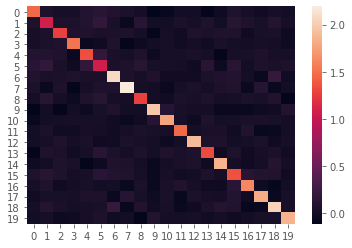

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.20197
 MSE with beta :  0.74609
ELBO :  688561.75115
Delta :  511312.8082869844
---------------------------------Maximum number of iterations reached :  1 last delta =  511312.8082869844
 MSE with Sigma :  0.20197
 MSE with beta :  0.74609
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08568
 MSE with beta :  0.33759
ELBO :  1066145.65497
Delta :  377583.90382132214
---------------------------------Maximum number of iterations reached :  1 last delta =  377583.90382132214
 MSE with Sigma :  0.08568
 MSE with beta :  0.33759
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12227
 MSE with beta :  0.18248
ELBO :  1454147.36775
Delta :  388001.71278241
---------------------------------Maximum number of iterations reached :  1 last delta =  388001.71278241
 MSE with Sigma :  0.12227
 MSE with beta :  0.18248
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.16164
 MSE with beta :  0.16

In [88]:
model_VEM = PLN_full()
%time model_VEM.VEM_both_closed(data,Number_VEM_step =10, N_epoch_max = 1,verbose=True, lr = 1)

# Parametrisation centered in $0$ and variance $I$


## Gradient descent with the PCA formula

In [90]:
model_PCA = PLN_full()
%time model_PCA.full_grad_ascent_PCA(data, N_epoch = 10,verbose=True, lr = 0.7)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.71658
 MSE with beta :  1.12602
ELBO :  -773254008.66387
Delta :  -773254007.6638677
---------------------------------Maximum number of iterations reached :  10 last delta =  198357.74631300988
 MSE with Sigma :  0.56358
 MSE with beta :  1.39303
CPU times: user 184 ms, sys: 16.5 ms, total: 200 ms
Wall time: 34 ms


# Parametrisation centered in 0 and variance Sigma

## VEM of the first notebook  

In [95]:
model_first_VEM = PLN_full()
%time model_first_VEM.first_VEM(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 1)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.41262
 MSE with beta :  1.19661
ELBO :  284159.42754
Delta :  284160.4275400857
---------------------------------Maximum number of iterations reached :  20 last delta =  1353.0013581234962
 MSE with Sigma :  0.41262
 MSE with beta :  1.03427
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.39523
 MSE with beta :  1.01631
ELBO :  2131064.2182
Delta :  20131.511599425226
---------------------------------Maximum number of iterations reached :  20 last delta =  98.19209395442158
 MSE with Sigma :  0.39523
 MSE with beta :  0.91855
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.20757
 MSE with beta :  0.9171
ELBO :  2150643.65423
Delta :  2589.9499108139426
---------------------------------Maximum number of iterations reached :  20 last delta =  10.97175069572404
 MSE with Sigma :  0.20757
 MSE with beta :  0.89556
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.17348
 MSE with beta :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.17593764699995518
 MSE with Sigma :  0.07223
 MSE with beta :  0.47466
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0713
 MSE with beta :  0.47429
ELBO :  2154156.09762
Delta :  0.20082147559151053
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1662351149134338
 MSE with Sigma :  0.0713
 MSE with beta :  0.46483
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07042
 MSE with beta :  0.46445
ELBO :  2154159.94995
Delta :  0.21660085255280137
---------------------------------Maximum number of iterations reached :  20 last delta =  0.21802168060094118
 MSE with Sigma :  0.07042
 MSE with beta :  0.45513
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.06957
 MSE with beta :  0.45478
ELBO :  2154163.66068
Delta :  0.19573367619886994
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.09423193382099271
 MSE with Sigma :  0.05725
 MSE with beta :  0.29559
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05699
 MSE with beta :  0.29542
ELBO :  2154228.30404
Delta :  0.08818813599646091
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08513582544401288
 MSE with Sigma :  0.05699
 MSE with beta :  0.29215
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05675
 MSE with beta :  0.29198
ELBO :  2154229.97103
Delta :  0.09483647253364325
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08532252721488476
 MSE with Sigma :  0.05675
 MSE with beta :  0.28846
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05651
 MSE with beta :  0.28829
ELBO :  2154231.72152
Delta :  0.08755963202565908
---------------------------------Maximum number of iterations reached :  

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03533062897622585
 MSE with Sigma :  0.05297
 MSE with beta :  0.22173
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05289
 MSE with beta :  0.22165
ELBO :  2154264.38127
Delta :  0.04114578850567341
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04244548501446843
 MSE with Sigma :  0.05289
 MSE with beta :  0.21963
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05282
 MSE with beta :  0.21959
ELBO :  2154265.24692
Delta :  0.03761884616687894
---------------------------------Maximum number of iterations reached :  20 last delta =  0.044562868773937225
 MSE with Sigma :  0.05282
 MSE with beta :  0.21814
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05274
 MSE with beta :  0.21802
ELBO :  2154266.06736
Delta :  0.047517099883407354
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.022010282147675753
 MSE with Sigma :  0.05132
 MSE with beta :  0.18546
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05127
 MSE with beta :  0.18542
ELBO :  2154282.93281
Delta :  0.022536075208336115
---------------------------------Maximum number of iterations reached :  20 last delta =  0.017947508487850428
 MSE with Sigma :  0.05127
 MSE with beta :  0.18469
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05124
 MSE with beta :  0.18465
ELBO :  2154283.33899
Delta :  0.018406454008072615
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01678952295333147
 MSE with Sigma :  0.05124
 MSE with beta :  0.18393
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05121
 MSE with beta :  0.18389
ELBO :  2154283.72035
Delta :  0.015548470430076122
---------------------------------Maximum number of iterations reache

---------------------------------Maximum number of iterations reached :  20 last delta =  0.01227071089670062
 MSE with Sigma :  0.05042
 MSE with beta :  0.16359
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0504
 MSE with beta :  0.16356
ELBO :  2154294.26797
Delta :  0.0130850481800735
---------------------------------Maximum number of iterations reached :  20 last delta =  0.014287855476140976
 MSE with Sigma :  0.0504
 MSE with beta :  0.1629
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05037
 MSE with beta :  0.16288
ELBO :  2154294.60507
Delta :  0.01924657914787531
---------------------------------Maximum number of iterations reached :  20 last delta =  0.013468091376125813
 MSE with Sigma :  0.05037
 MSE with beta :  0.16234
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05035
 MSE with beta :  0.1623
ELBO :  2154294.89839
Delta :  0.013895068783313036
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.012028138153254986
 MSE with Sigma :  0.04983
 MSE with beta :  0.14687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04981
 MSE with beta :  0.14684
ELBO :  2154302.26819
Delta :  0.011003919411450624
---------------------------------Maximum number of iterations reached :  20 last delta =  0.009154310449957848
 MSE with Sigma :  0.04981
 MSE with beta :  0.14632
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04979
 MSE with beta :  0.14629
ELBO :  2154302.52785
Delta :  0.010730743873864412
---------------------------------Maximum number of iterations reached :  20 last delta =  0.012254169676452875
 MSE with Sigma :  0.04979
 MSE with beta :  0.14574
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04977
 MSE with beta :  0.14571
ELBO :  2154302.78696
Delta :  0.012956289108842611
---------------------------------Maximum number of iterations reach

---------------------------------Maximum number of iterations reached :  20 last delta =  0.009535739663988352
 MSE with Sigma :  0.04941
 MSE with beta :  0.13289
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04939
 MSE with beta :  0.13286
ELBO :  2154308.53699
Delta :  0.011804802343249321
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008259000722318888
 MSE with Sigma :  0.04939
 MSE with beta :  0.13252
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04938
 MSE with beta :  0.1325
ELBO :  2154308.69515
Delta :  0.009081809315830469
---------------------------------Maximum number of iterations reached :  20 last delta =  0.010931207332760096
 MSE with Sigma :  0.04938
 MSE with beta :  0.13207
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04937
 MSE with beta :  0.13204
ELBO :  2154308.91099
Delta :  0.0101616270840168
---------------------------------Maximum number of iterations reached 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.005200293380767107
 MSE with Sigma :  0.04911
 MSE with beta :  0.12198
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0491
 MSE with beta :  0.12197
ELBO :  2154313.41778
Delta :  0.005573909729719162
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005973811261355877
 MSE with Sigma :  0.0491
 MSE with beta :  0.12164
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04909
 MSE with beta :  0.12163
ELBO :  2154313.57053
Delta :  0.00676850276067853
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004707973916083574
 MSE with Sigma :  0.04909
 MSE with beta :  0.12135
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04908
 MSE with beta :  0.12134
ELBO :  2154313.69147
Delta :  0.00497081084176898
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.011132118757814169
 MSE with Sigma :  0.0489
 MSE with beta :  0.11332
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04889
 MSE with beta :  0.11331
ELBO :  2154317.29934
Delta :  0.007831056136637926
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0059944335371255875
 MSE with Sigma :  0.04889
 MSE with beta :  0.11305
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04889
 MSE with beta :  0.11304
ELBO :  2154317.43156
Delta :  0.006736160255968571
---------------------------------Maximum number of iterations reached :  20 last delta =  0.007300384342670441
 MSE with Sigma :  0.04889
 MSE with beta :  0.1128
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04888
 MSE with beta :  0.11278
ELBO :  2154317.54946
Delta :  0.008223394397646189
---------------------------------Maximum number of iterations reache

---------------------------------Maximum number of iterations reached :  20 last delta =  0.004673797637224197
 MSE with Sigma :  0.04876
 MSE with beta :  0.10668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04875
 MSE with beta :  0.10668
ELBO :  2154320.31523
Delta :  0.0050557563081383705
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004880546126514673
 MSE with Sigma :  0.04875
 MSE with beta :  0.10648
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04875
 MSE with beta :  0.10647
ELBO :  2154320.41784
Delta :  0.004995218478143215
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0033639781177043915
 MSE with Sigma :  0.04875
 MSE with beta :  0.1063
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04874
 MSE with beta :  0.10629
ELBO :  2154320.50711
Delta :  0.0036172284744679928
---------------------------------Maximum number of iterations rea

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04866
 MSE with beta :  0.10219
ELBO :  2154322.43406
Delta :  0.0028067436069250107
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0048264795914292336
 MSE with Sigma :  0.04866
 MSE with beta :  0.10204
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04866
 MSE with beta :  0.10203
ELBO :  2154322.50835
Delta :  0.004495886154472828
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002814529463648796
 MSE with Sigma :  0.04866
 MSE with beta :  0.10192
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04866
 MSE with beta :  0.10191
ELBO :  2154322.56754
Delta :  0.0031260880641639233
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0025619911029934883
 MSE with Sigma :  0.04866
 MSE with beta :  0.10176
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0022301715798676014
 MSE with Sigma :  0.04859
 MSE with beta :  0.09844
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04859
 MSE with beta :  0.09844
ELBO :  2154324.2131
Delta :  0.0022536367177963257
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0015316014178097248
 MSE with Sigma :  0.04859
 MSE with beta :  0.09834
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04858
 MSE with beta :  0.09834
ELBO :  2154324.2601
Delta :  0.002166897989809513
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002546964678913355
 MSE with Sigma :  0.04858
 MSE with beta :  0.09823
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04858
 MSE with beta :  0.09822
ELBO :  2154324.31085
Delta :  0.0028013144619762897
---------------------------------Maximum number of iterations rea

---------------------------------Maximum number of iterations reached :  20 last delta =  0.003669717814773321
 MSE with Sigma :  0.04853
 MSE with beta :  0.09539
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04853
 MSE with beta :  0.09538
ELBO :  2154325.75165
Delta :  0.0038990145549178123
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004135823808610439
 MSE with Sigma :  0.04853
 MSE with beta :  0.09529
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04852
 MSE with beta :  0.09528
ELBO :  2154325.80959
Delta :  0.0025262092240154743
---------------------------------Tolerance 0.00026041666666666666 reached in 18 iterations
 MSE with Sigma :  0.04852
 MSE with beta :  0.0952
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04852
 MSE with beta :  0.0952
ELBO :  2154325.85678
Delta :  0.0025919871404767036
---------------------------------Maximum number of iterations reached :  20 last delta

---------------------------------Maximum number of iterations reached :  20 last delta =  0.002138046082109213
 MSE with Sigma :  0.04849
 MSE with beta :  0.09316
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04849
 MSE with beta :  0.09316
ELBO :  2154326.94934
Delta :  0.002337386831641197
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0019001467153429985
 MSE with Sigma :  0.04849
 MSE with beta :  0.0931
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04848
 MSE with beta :  0.09309
ELBO :  2154326.98784
Delta :  0.002022028900682926
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0007802858017385006
 MSE with Sigma :  0.04848
 MSE with beta :  0.09304
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04848
 MSE with beta :  0.09303
ELBO :  2154327.02271
Delta :  0.0011963453143835068
---------------------------------Maximum number of iterations rea

---------------------------------Tolerance 0.00022522522522522523 reached in 17 iterations
 MSE with Sigma :  0.04846
 MSE with beta :  0.09159
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04846
 MSE with beta :  0.09159
ELBO :  2154327.83122
Delta :  0.0005703503265976906
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001640321221202612
 MSE with Sigma :  0.04846
 MSE with beta :  0.09154
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04846
 MSE with beta :  0.09154
ELBO :  2154327.85689
Delta :  0.000669015571475029
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0016589732840657234
 MSE with Sigma :  0.04846
 MSE with beta :  0.0915
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04846
 MSE with beta :  0.0915
ELBO :  2154327.88333
Delta :  0.00177377974614501
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012047253549098969
 MSE with Sigma :  0.04844
 MSE with beta :  0.09049
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04844
 MSE with beta :  0.09048
ELBO :  2154328.54977
Delta :  0.0013689869083464146
---------------------------------Tolerance 0.0002105263157894737 reached in 16 iterations
 MSE with Sigma :  0.04844
 MSE with beta :  0.09046
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04844
 MSE with beta :  0.09046
ELBO :  2154328.57288
Delta :  0.003071769140660763
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001016900409013033
 MSE with Sigma :  0.04844
 MSE with beta :  0.09043
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04843
 MSE with beta :  0.09042
ELBO :  2154328.59464
Delta :  0.0011295760050415993
---------------------------------Maximum number of iterations reached :  20 last delt

ELBO :  2154329.07162
Delta :  0.0006490298546850681
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0008999365381896496
 MSE with Sigma :  0.04842
 MSE with beta :  0.0896
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04842
 MSE with beta :  0.0896
ELBO :  2154329.0885
Delta :  0.0010421918705105782
---------------------------------Tolerance 0.00019723865877712034 reached in 6 iterations
 MSE with Sigma :  0.04842
 MSE with beta :  0.08959
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04842
 MSE with beta :  0.08959
ELBO :  2154329.09561
Delta :  0.0019286591559648514
---------------------------------Tolerance 0.00019685039370078743 reached in 5 iterations
 MSE with Sigma :  0.04842
 MSE with beta :  0.08959
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04842
 MSE with beta :  0.08959
ELBO :  2154329.09742
Delta :  0.0005966108292341232
---------------------------------Tolerance 0.0001964636

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0007224972359836102
 MSE with Sigma :  0.04841
 MSE with beta :  0.08901
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04841
 MSE with beta :  0.08901
ELBO :  2154329.51255
Delta :  0.0009998278692364693
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0004496946930885315
 MSE with Sigma :  0.04841
 MSE with beta :  0.08899
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04841
 MSE with beta :  0.08899
ELBO :  2154329.52445
Delta :  0.0005076532252132893
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0007670675404369831
 MSE with Sigma :  0.04841
 MSE with beta :  0.08897
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04841
 MSE with beta :  0.08897
ELBO :  2154329.53642
Delta :  0.0007969383150339127
---------------------------------Maximum number of iterations

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0005720229819417
 MSE with Sigma :  0.0484
 MSE with beta :  0.08857
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08857
ELBO :  2154329.86167
Delta :  0.0006077084690332413
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0008102771826088428
 MSE with Sigma :  0.0484
 MSE with beta :  0.08856
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08856
ELBO :  2154329.87507
Delta :  0.001115142833441496
---------------------------------Maximum number of iterations reached :  20 last delta =  0.000342467799782753
 MSE with Sigma :  0.0484
 MSE with beta :  0.08855
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08855
ELBO :  2154329.88461
Delta :  0.000531414058059454
---------------------------------Tolerance 0.00017452006980802793 reached

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0005892049521207809
 MSE with Sigma :  0.0484
 MSE with beta :  0.08828
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08828
ELBO :  2154330.09477
Delta :  0.0006123017519712448
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00041087623685598373
 MSE with Sigma :  0.0484
 MSE with beta :  0.08827
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08827
ELBO :  2154330.10398
Delta :  0.0004084985703229904
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0002741888165473938
 MSE with Sigma :  0.0484
 MSE with beta :  0.08826
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0484
 MSE with beta :  0.08826
ELBO :  2154330.11081
Delta :  0.0003449413925409317
---------------------------------Maximum number of iterations reac

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00036368612200021744
 MSE with Sigma :  0.04839
 MSE with beta :  0.0881
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0881
ELBO :  2154330.28662
Delta :  0.00034018978476524353
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00029061781242489815
 MSE with Sigma :  0.04839
 MSE with beta :  0.0881
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0881
ELBO :  2154330.29401
Delta :  0.0002607586793601513
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00027923984453082085
 MSE with Sigma :  0.04839
 MSE with beta :  0.08809
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08809
ELBO :  2154330.29967
Delta :  0.0002869581803679466
---------------------------------Tolerance 0.0001592356687898

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0003023003228008747
 MSE with Sigma :  0.04839
 MSE with beta :  0.08793
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08793
ELBO :  2154330.43811
Delta :  0.00028112344443798065
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00026907259598374367
 MSE with Sigma :  0.04839
 MSE with beta :  0.08792
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08792
ELBO :  2154330.44313
Delta :  0.0002501457929611206
---------------------------------Tolerance 0.00015151515151515152 reached in 14 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08792
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08792
ELBO :  2154330.44616
Delta :  0.00013718055561184883
---------------------------------Tolerance 0.00015128593040847203 reached in 1 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00032354099676012993
 MSE with Sigma :  0.04839
 MSE with beta :  0.08784
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08784
ELBO :  2154330.54188
Delta :  0.0002857116051018238
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00026129139587283134
 MSE with Sigma :  0.04839
 MSE with beta :  0.08783
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08783
ELBO :  2154330.54674
Delta :  0.0003364081494510174
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00021291570737957954
 MSE with Sigma :  0.04839
 MSE with beta :  0.08783
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08783
ELBO :  2154330.5513
Delta :  0.00020111817866563797
---------------------------------Maximum number of iterati

---------------------------------Tolerance 0.00013774104683195594 reached in 11 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
ELBO :  2154330.62011
Delta :  0.0002000303938984871
---------------------------------Tolerance 0.0001375515818431912 reached in 2 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
ELBO :  2154330.62035
Delta :  0.0001360592432320118
---------------------------------Tolerance 0.00013736263736263736 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08776
ELBO :  2154330.62045
Delta :  9.927107021212578e-05
---------------------------------Tolerance 0.00013717421124828533 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with 

---------------------------------Tolerance 0.00013262599469496023 reached in 20 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08775
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08775
ELBO :  2154330.65547
Delta :  0.0003981073386967182
---------------------------------Tolerance 0.00013245033112582781 reached in 16 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08774
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08774
ELBO :  2154330.6588
Delta :  0.0002524303272366524
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00023016845807433128
 MSE with Sigma :  0.04839
 MSE with beta :  0.08774
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08774
ELBO :  2154330.66356
Delta :  0.00025412486866116524
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0002691536

---------------------------------Tolerance 0.00012626262626262626 reached in 4 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
ELBO :  2154330.72329
Delta :  0.0001303921453654766
---------------------------------Tolerance 0.00012610340479192938 reached in 7 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
ELBO :  2154330.72446
Delta :  0.00019196979701519012
---------------------------------Tolerance 0.00012594458438287153 reached in 12 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08772
ELBO :  2154330.72694
Delta :  0.00028894422575831413
---------------------------------Tolerance 0.00012578616352201257 reached in 3 iterations
 MSE with Sigma :  0.04839
 MSE wi

---------------------------------Tolerance 0.00012033694344163659 reached in 13 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
ELBO :  2154330.76885
Delta :  0.00014160200953483582
---------------------------------Tolerance 0.0001201923076923077 reached in 4 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
ELBO :  2154330.76934
Delta :  0.00011368049308657646
---------------------------------Tolerance 0.00012004801920768308 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08771
ELBO :  2154330.76946
Delta :  0.00012420210987329483
---------------------------------Tolerance 0.00011990407673860912 reached in 6 iterations
 MSE with Sigma :  0.04839
 MSE wi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
ELBO :  2154330.80338
Delta :  0.00013423850759863853
---------------------------------Tolerance 0.00011325028312570782 reached in 13 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
ELBO :  2154330.80554
Delta :  0.00013886438682675362
---------------------------------Tolerance 0.00011312217194570136 reached in 3 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
ELBO :  2154330.80599
Delta :  0.0001532137393951416
---------------------------------Tolerance 0.00011299435028248589 reached in 2 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.08769
ELBO :  2154330.80613
Delta :

---------------------------------Tolerance 0.00010845986984815619 reached in 14 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.82372
Delta :  0.00010116491466760635
---------------------------------Tolerance 0.00010834236186348862 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.82382
Delta :  0.00010211160406470299
---------------------------------Tolerance 0.00010822510822510823 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.8239
Delta :  7.843039929866791e-05
---------------------------------Tolerance 0.00010810810810810812 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta

---------------------------------Tolerance 0.00010395010395010396 reached in 8 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.84249
Delta :  0.00011400226503610611
---------------------------------Tolerance 0.00010384215991692627 reached in 7 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.84324
Delta :  8.200714364647865e-05
---------------------------------Tolerance 0.00010373443983402491 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.84334
Delta :  9.965524077415466e-05
---------------------------------Tolerance 0.00010362694300518135 reached in 1 iterations
 MSE with Sigma :  0.04839
 MSE with beta 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00015823356807231903
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.86544
Delta :  0.00014548702165484428
---------------------------------Tolerance 0.0001002004008016032 reached in 8 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.8665
Delta :  0.00013608532026410103
---------------------------------Tolerance 0.0001001001001001001 reached in 2 iterations
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04839
 MSE with beta :  0.0877
ELBO :  2154330.86671
Delta :  0.00012386729940772057
---------------------------------Tolerance 0.0001 reached in 17 iterations
 MSE with Sigma :  0.04839
 MSE wit

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 

PARAMETRISATION CENTERED IN $X\beta$ and variance $\Sigma$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$



If we use $C$ instead of $\Sigma$ : 


PARAMETRISATION CENTERED IN $X\beta$ and variance $CC^{\top}$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{i} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+ ZC\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_i \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{j}^{\top} Z_i\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{j k}Z_{ik}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{j k} Z_{i k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{j k} Z_{i k}\right)\right] \\ 
&=\prod_{k=1}^{p} exp \left(M_{i_{k}} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&= \exp \left(\sum_{k=1}^{p} M_{i k} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&=\exp \left(M_{i}^{\top} C_{j}+\frac{\left(S_{i}^{2}\right)^{T} C_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top} +\frac{  (S \odot S)(C\odot C)^{\top}}{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

PARAMETRISATION CENTERED IN 0 AND UNIT VARIANCE 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+MC^{\top}) - \frac{1}{2} \operatorname{exp}\left(O+X\beta+MC^{\top}+\frac{(S \odot S)(C\odot C)^{\top}}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

We have for the gradients : 

$$
\nabla_{\beta}=X^{\top} Y-\frac{1}{2} X^{\top} \exp \left(0+X \beta+M C^{\top}+\frac{\left(S\odot S\right)\left(C\odot C\right)^{\top}}{2}\right)
$$

We can have a last parametrization that is : 

$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$

and 


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$

This model is equivalent to the other ones but the optimization is different.  

PARAMETRISATION CENTERED IN 0 AND VARIANCE $\Sigma$

$$
\boxed{
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|(S\odot S)_{i}\right|+c s t .
\end{aligned}}
$$
    

## test with the fastPLN file

In [11]:
from fastPLN import fastPLN 

In [14]:
model = fastPLN()
model.fit(Y_sampled,O,covariates, 100)

<AxesSubplot:>

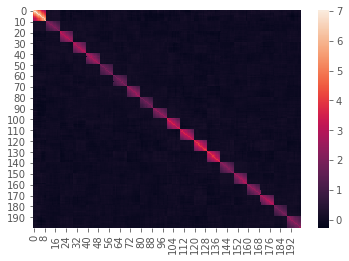

In [18]:
sns.heatmap(model.Sigma.detach().numpy())

## test with oaks data 
